In [ ]:
!pip install visualkeras

#imports
import numpy as np
import pandas as pd
import os
import random
import cv2
from sklearn.metrics import confusion_matrix


#tensorflow library
import tensorflow as tf
from keras.models import Model
from keras.layers import Flatten, Dropout, Dense
from keras.preprocessing import image
from keras.applications import VGG16, MobileNet
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import visualkeras


#visualization library
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pokemon_folder= "/content/drive/MyDrive/ML_project/dataset"

total_image_count = 1

for root, dirs, files in os.walk(pokemon_folder):
  for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
            total_image_count += 1

print('The folder has',total_image_count,'images')



The folder has 5000 images


***Removing dodgy images***


```
image_exts=['jpeg','jpg','bmp','png','gif'] (The only extentions allowed by tensorflow)

for image_class in os.listdir(pokemon_folder):
  for image in os.listdir(os.path.join(pokemon_folder,image_class)):
    image_path= os.path.join(pokemon_folder, image_class, image)

    try:
        img= cv2.imread(image_path)
        tip= imghdr.what(image_path)
        if tip not in image_exts:
          print('Image not in ext list {}'.format(image_path))
          os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))
```



#### Data Augmentation

In [ ]:
slowpoke_folder = os.path.join(pokemon_folder,'Slowpoke')


In [ ]:
def plotimages(images_arr):
  fig,axes= plt.subplots(1,10,figsize=(20,20))
  axes= axes.flatten()
  for img, ax in zip(images_arr,axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
datagen =  ImageDataGenerator(
        rotation_range=45,     #Random rotation between 0 and 45
        width_shift_range=0.2,   #% shift
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='constant', cval=125)




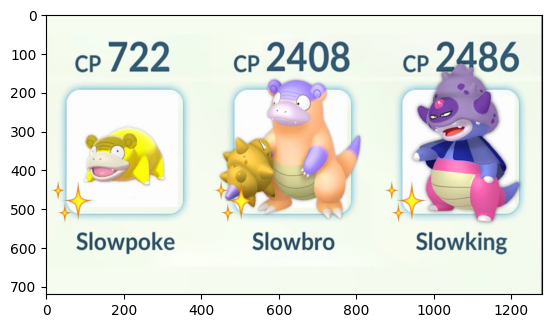

In [ ]:
img = random.choice(os.listdir(slowpoke_folder)) #randomly select one image from the specific folder
image_path= slowpoke_folder+'/'+ img  #create the path of the image
image= np.expand_dims(plt.imread(image_path),0)  #xpands the dimensions of an array (at the first position)
plt.imshow(image[0])

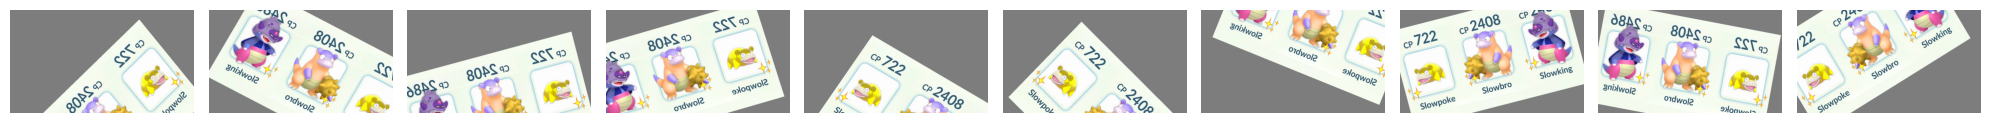

In [ ]:
aug_iter = datagen.flow(image)#save_to_dir= slowpoke_folder)
aug_images= [next(aug_iter)[0].astype(np.uint8) for i in range(25)] #generate 25 new images
plotimages(aug_images)

#### Loading data

In [ ]:
batch_size= 32
image_size= (256,256)

pokemon_ds = tf.keras.utils.image_dataset_from_directory(pokemon_folder,
            batch_size=batch_size,
            image_size=image_size,
            shuffle=True)

Found 4999 files belonging to 5 classes.


In [ ]:
# Get the first batch of data (images and labels)
for images, labels in pokemon_ds.take(1):
    # Check if the order of images is different from the original order
    if not tf.reduce_all(tf.equal(images, tf.sort(images))):
        print("The dataset is shuffled.")
    else:
        print("The dataset is not shuffled.")

The dataset is shuffled.


In [ ]:
class_names = pokemon_ds.class_names
print(class_names)

['Charmander', 'Mewtwo', 'Pikachu', 'Slowpoke', 'Squirtle']


In [ ]:
pokemon_iterator = pokemon_ds.as_numpy_iterator()
batch = pokemon_iterator.next()

In [ ]:
batch[1]
#class 0: Charmander
#class 1: Mewtwo
#class 2: Pikachu
#class 3: Slowpoke
#class 4: Squirtle

array([4, 0, 4, 0, 2, 3, 3, 1, 0, 1, 0, 1, 1, 2, 1, 4, 0, 2, 0, 1, 1, 0,
       4, 0, 0, 2, 3, 1, 0, 1, 2, 3], dtype=int32)

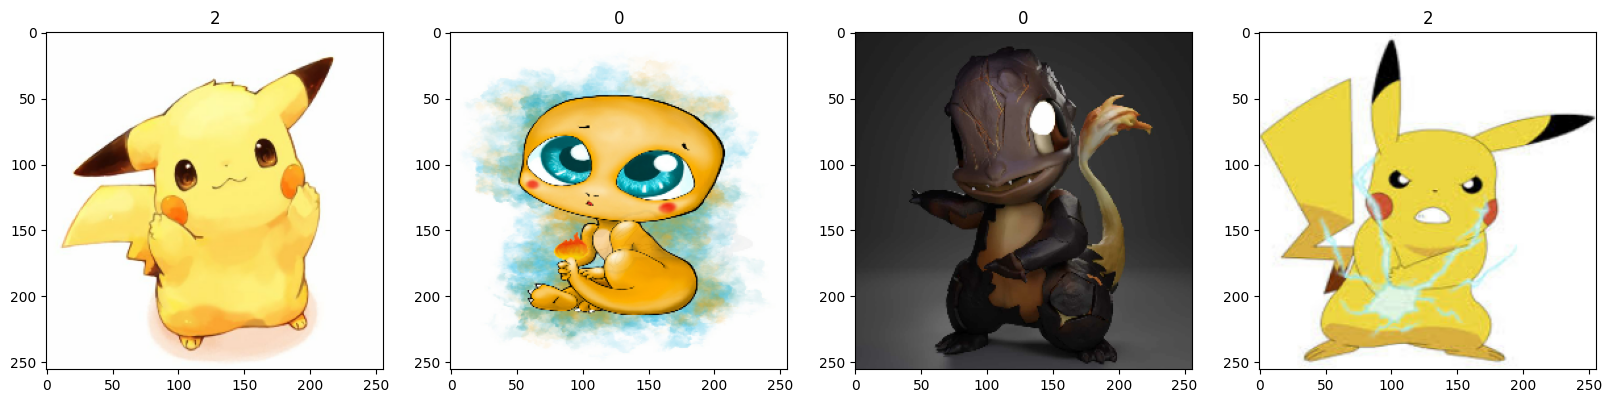

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
print('The shape of each batch is:', batch[0].shape)
print('The lowest colour value in the RGB scale:',batch[0].min())
print('The highest colour value in the RGB scale:',batch[0].max())


The shape of each batch is: (32, 256, 256, 3)
The lowest colour value in the RGB scale: 0.0
The highest colour value in the RGB scale: 255.0


## Preprocess Data

### Normalize Data

In [ ]:
#the value of the RGB channel are encompassed in the interval [0,255]. This is not appropriate for a neural network.
#We need to rescale it from 0 to 1

pokemon_ds = pokemon_ds.map(lambda x, y:(x/255,y))

pokemon_iterator=pokemon_ds.as_numpy_iterator()
batch=pokemon_iterator.next()

In [ ]:
print('The lowest colour value in the normalized RGB scale:',batch[0].min())
print('The highest colour value in the normalized RGB scale:',batch[0].max())

The lowest colour value in the normalized RGB scale: 0.0
The highest colour value in the normalized RGB scale: 1.0


#### Split dataset

In [ ]:
train_sample = round(len(pokemon_ds)*.7)
print('The number of batches used for training are:',train_sample)

val_sample = round(len(pokemon_ds)*.2)
print('The number of batches used for validation are:',val_sample)

test_sample= round(len(pokemon_ds)*.1)
print('The number of batches used for testing are:',test_sample)

print('---------------------------------------------------')

print('The total number of batches in the dataset are:', len(pokemon_ds))
print('The total number of batches after splitting are::',train_sample+val_sample+test_sample)

The number of batches used for training are: 110
The number of batches used for validation are: 31
The number of batches used for testing are: 16
---------------------------------------------------
The total number of batches in the dataset are: 157
The total number of batches after splitting are:: 157


In [ ]:
#Use take and skip function: take defines how many data the model is going to take in each particular partition

train= pokemon_ds.take(train_sample)
print('The number of batches allocated for training are:', len(train))

val=pokemon_ds.skip(train_sample).take(val_sample)
print('The number of batches allocated for validation are:', len(val))

test= pokemon_ds.skip(train_sample+val_sample).take(test_sample)
print('The number of batches allocated for test are:', len(test))

The number of batches allocated for training are: 110
The number of batches allocated for validation are: 31
The number of batches allocated for test are: 16


## VGG16 Model

### VGG16 Architecture

In [ ]:
# Load the pre-trained VGG model pre-trained on the ImageNet dataset
pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in pretrained_model.layers:
    layer.trainable = False    #fine-tune only the layers for the classification task


x = Flatten()(pretrained_model.output)
x = Dropout(0.5)(x)  # Add dropout with a 50% dropout rate
predictions = Dense(5, activation='softmax')(x) #prediction into probabilities for multi-class

vgg_model = Model(inputs=pretrained_model.input, outputs=predictions)
vgg_model.summary()

vgg_model.compile(optimizer=Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])





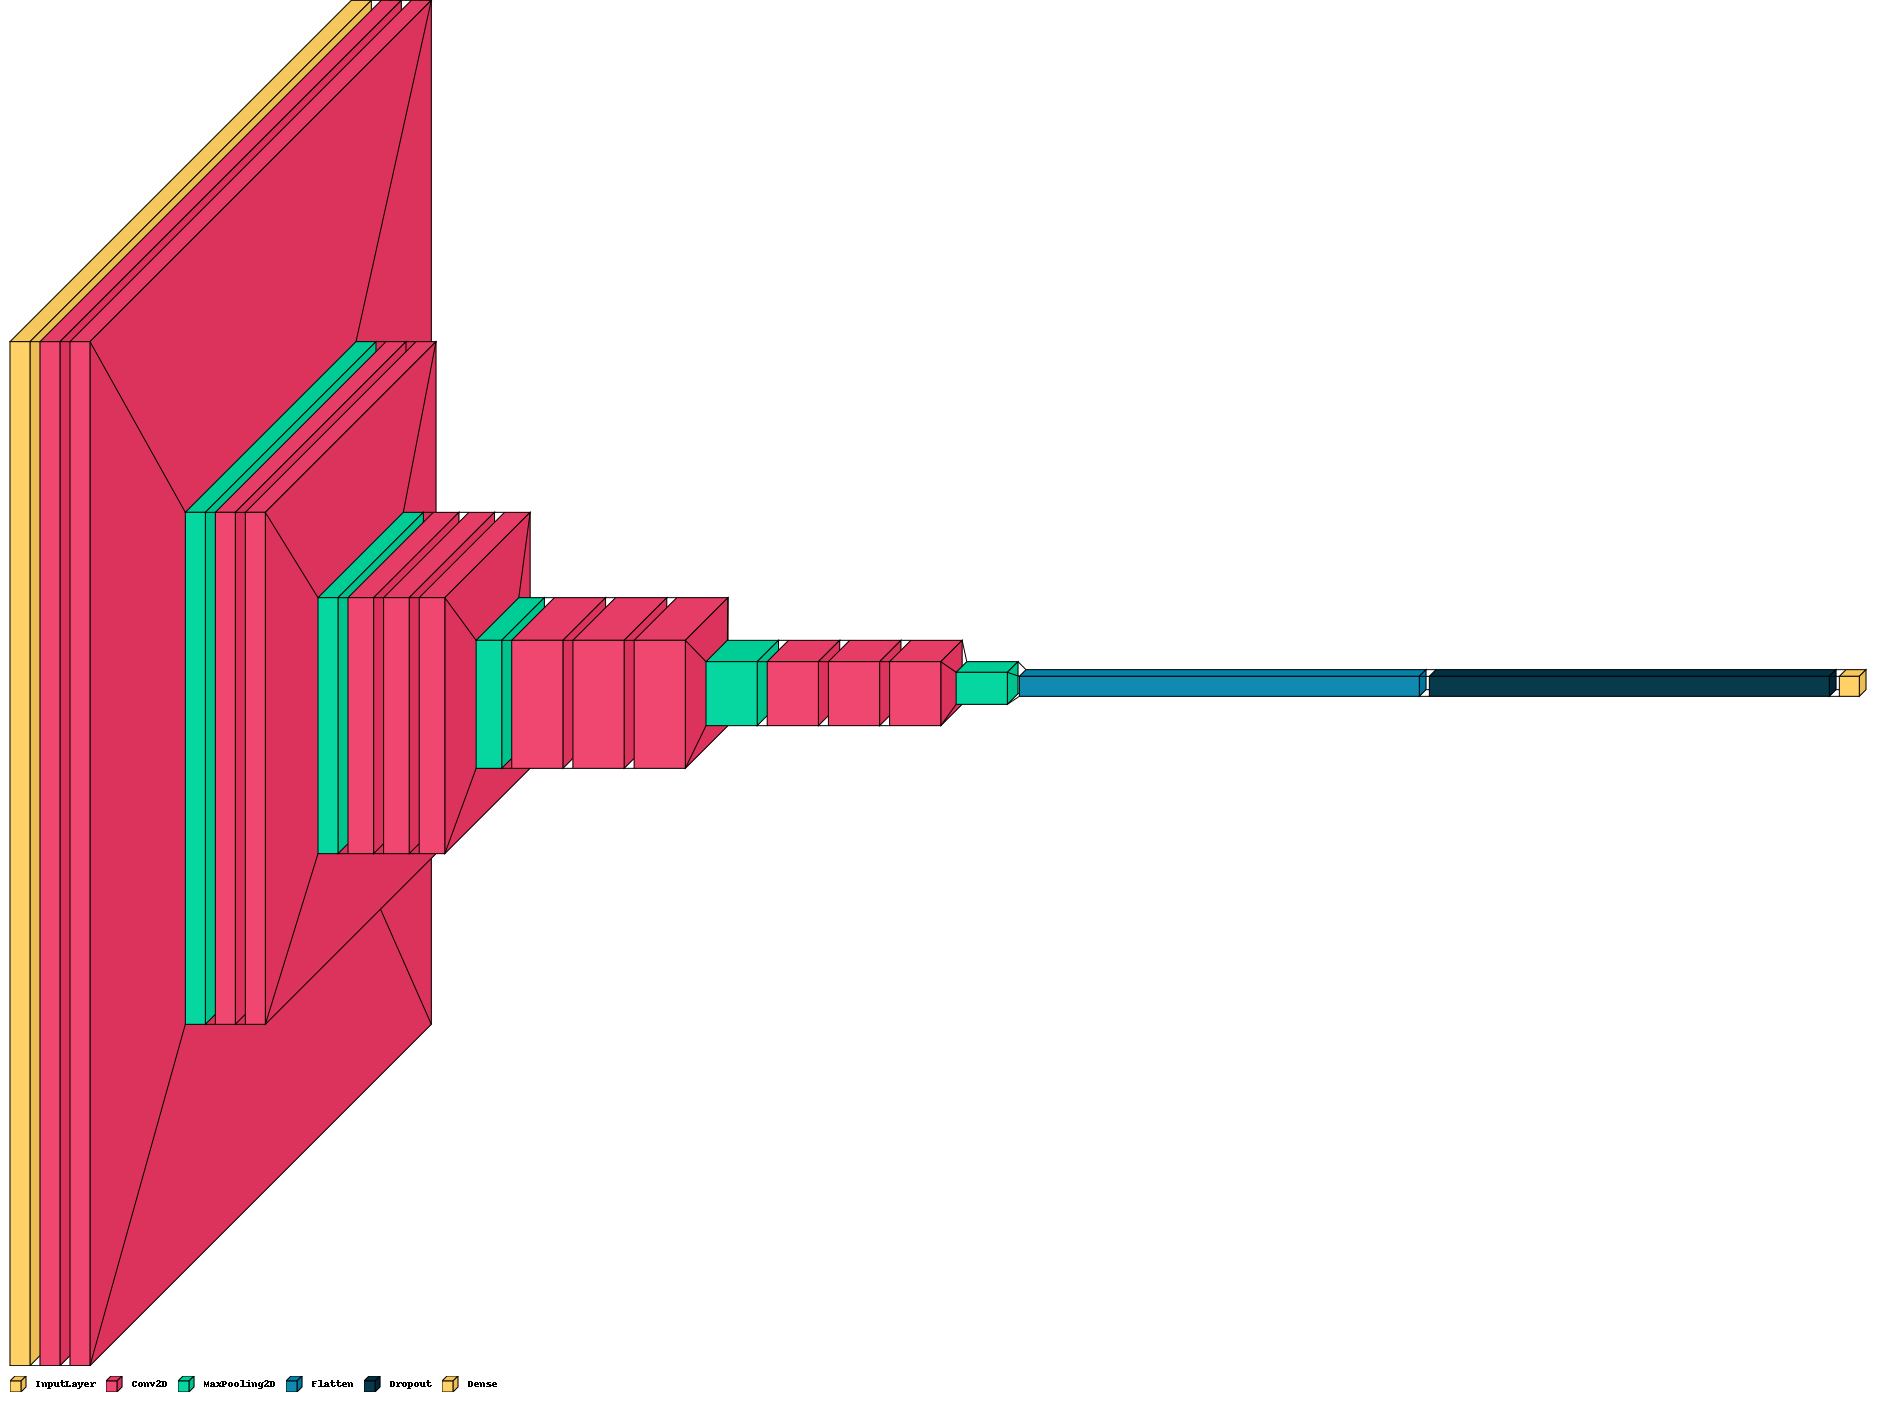

In [ ]:
visualkeras.layered_view(vgg_model, legend=True)

### Train the model

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=5,  # Number of epochs with no improvement before stopping
                               restore_best_weights=True)  # Restore the best model weights

In [ ]:
hist_vgg =vgg_model.fit(train, epochs=20, validation_data=val, callbacks=early_stopping)


Epoch 1/20
110/110 [==============================] - 473s 4s/step - loss: 1.0800 - accuracy: 0.6378 - val_loss: 0.5755 - val_accuracy: 0.8135
Epoch 2/20
110/110 [==============================] - 138s 1s/step - loss: 0.3427 - accuracy: 0.8778 - val_loss: 0.5188 - val_accuracy: 0.8397
Epoch 3/20
110/110 [==============================] - 137s 1s/step - loss: 0.2390 - accuracy: 0.9230 - val_loss: 0.5364 - val_accuracy: 0.8286
Epoch 4/20
110/110 [==============================] - 137s 1s/step - loss: 0.1476 - accuracy: 0.9554 - val_loss: 0.3698 - val_accuracy: 0.8780
Epoch 5/20
110/110 [==============================] - 136s 1s/step - loss: 0.0913 - accuracy: 0.9770 - val_loss: 0.3427 - val_accuracy: 0.8821
Epoch 6/20
110/110 [==============================] - 141s 1s/step - loss: 0.0727 - accuracy: 0.9835 - val_loss: 0.3619 - val_accuracy: 0.8821
Epoch 7/20
110/110 [==============================] - 136s 1s/step - loss: 0.0540 - accuracy: 0.9889 - val_loss: 0.4110 - val_accuracy: 0.8831

#### Plot Performance

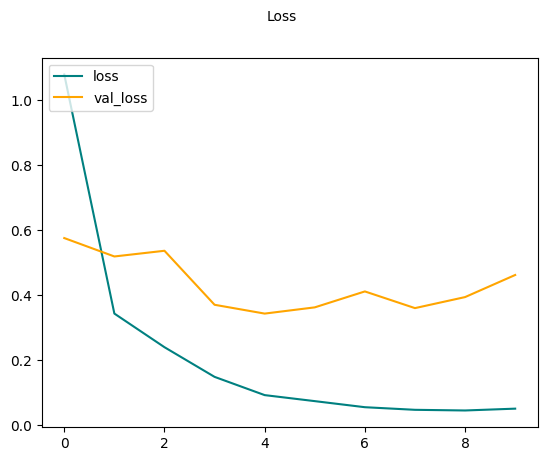

In [ ]:
fig = plt.figure()
plt.plot(hist_vgg.history['loss'], color='teal', label='loss')
plt.plot(hist_vgg.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper left")
plt.show()

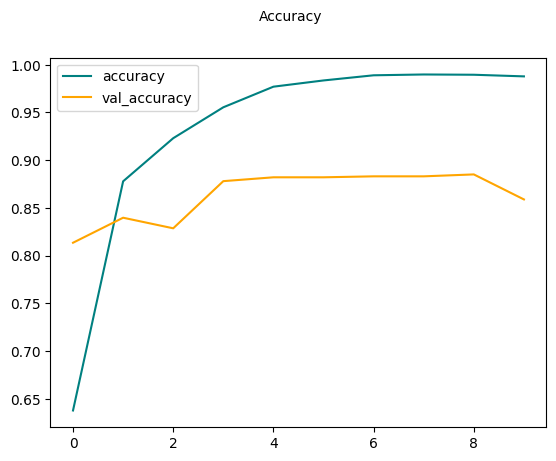

In [ ]:
fig = plt.figure()
plt.plot(hist_vgg.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_vgg.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="upper left")
plt.show()

### Evaluate the model

In [ ]:
test_loss, test_accuracy= vgg_model.evaluate(test)

16/16 [==============================] - 90s 2s/step - loss: 0.3756 - accuracy: 0.8747


In [ ]:
print('Loss:',test_loss)
print('Accuracy:', test_accuracy)

Loss: 0.3755922019481659
Accuracy: 0.8747433423995972


In [ ]:
true_labels = []
predicted_labels = []

for batch in test.as_numpy_iterator():
    img, label = batch
    pred= vgg_model.predict(img)

    true_labels.extend(label)
    predicted_labels.extend(np.argmax(pred, axis=1))



1/1 [==============================] - 0s 130ms/step


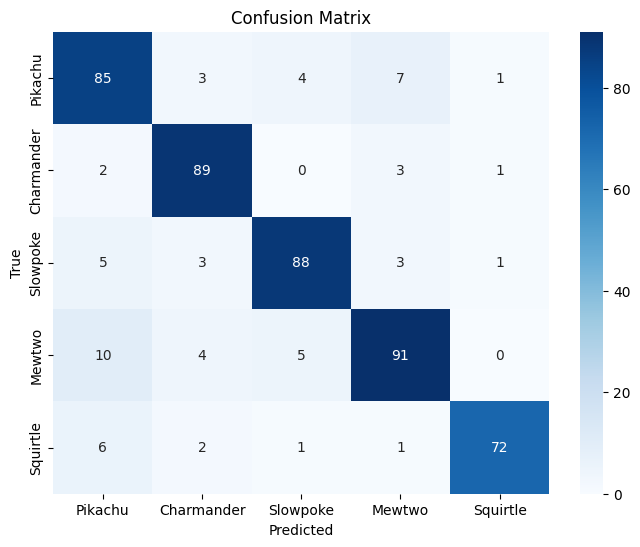

In [ ]:
# Calculate the confusion matrix for the entire test dataset
cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)

# Define class labels (modify as per your actual class labels)
class_labels = ['Pikachu', 'Charmander', 'Slowpoke', 'Mewtwo','Squirtle']

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Make predictions

In [ ]:
test_folder= '/content/drive/MyDrive/ML_project/test_images'

In [ ]:
file_paths = []

for root, dirs, files in os.walk(test_folder):
    for file_name in files:
      file_path = os.path.join(root, file_name)  # Construct the full file path
      file_paths.append(file_path)

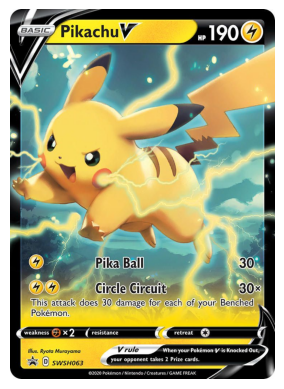

1/1 [==============================] - 1s 668ms/step
Prediction for /content/drive/MyDrive/ML_project/test_images/pikachu_3.jpeg
The predicted class is Pikachu
Class Labels and Probabilities:
Charmander: 0.020302
Mewtwo: 0.184954
Pikachu: 0.791890
Slowpoke: 0.002758
Squirtle: 0.000095

=====



In [ ]:
random_file_paths = random.sample(file_paths,1)

for image_path in random_file_paths:
    # Read the image
    pokemon_image = cv2.imread(str(image_path))

    # Display the image
    plt.imshow(cv2.cvtColor(pokemon_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Turn off axis labels
    plt.show()

    # Resize and preprocess the image
    image_resized = cv2.resize(pokemon_image, image_size)
    pokemon_image = np.expand_dims(image_resized/255, axis=0)

    # Make predictions using the model
    pred = vgg_model.predict(pokemon_image)
    formatted_pred = [(label, prob) for label, prob in zip(class_names, pred[0])]

    # Get the output class with the highest probability
    output_class = class_names[np.argmax(pred)]

    # Print prediction information
    print("Prediction for", image_path)
    print("The predicted class is", output_class)
    print("Class Labels and Probabilities:")
    for label, prob in formatted_pred:
      print(f"{label}: {prob:.6f}")
    print("\n" + "="*5 + "\n")  # Separator between images

In [ ]:
#saving the model in google drive
vgg_model.save(os.path.join('/content/drive/MyDrive/', 'pokemon__classifier_vgg16.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## MobileNet Model

### MobileNet Architecture

In [ ]:
pretrained_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in pretrained_model.layers:
    layer.trainable = False


x = Flatten()(pretrained_model.output)
x = Dropout(0.5)(x)  # Add dropout with a 50% dropout rate
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
predictions = Dense(5, activation='softmax')(x)

mob_model = Model(inputs=pretrained_model.input, outputs=predictions)
mob_model.summary()

mob_model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])



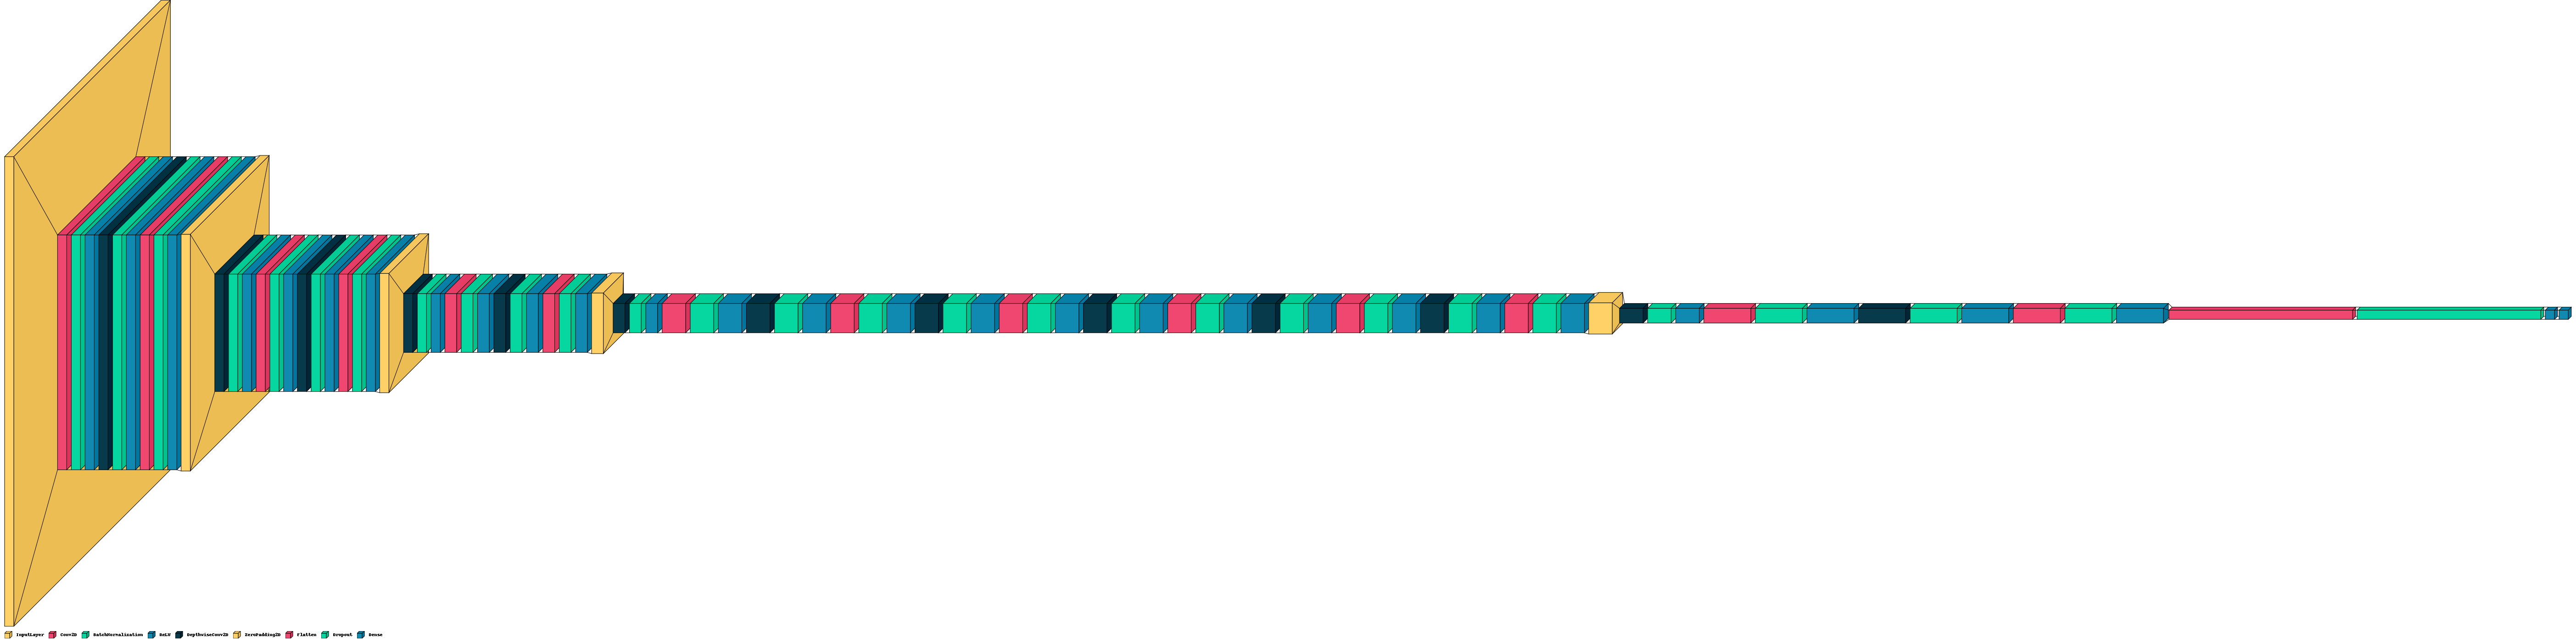

In [ ]:
visualkeras.layered_view(mob_model, legend=True)

### Train the model

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=5,  # Number of epochs with no improvement before stopping
                               restore_best_weights=True)  # Restore the best model weights

In [ ]:
hist_mob =mob_model.fit(train, epochs=20, validation_data=val, callbacks=early_stopping)

Epoch 1/20
110/110 [==============================] - 140s 1s/step - loss: 4.3626 - accuracy: 0.6983 - val_loss: 2.5123 - val_accuracy: 0.8558
Epoch 2/20
110/110 [==============================] - 135s 1s/step - loss: 1.8904 - accuracy: 0.9287 - val_loss: 1.6086 - val_accuracy: 0.8992
Epoch 3/20
110/110 [==============================] - 135s 1s/step - loss: 1.1759 - accuracy: 0.9702 - val_loss: 1.1720 - val_accuracy: 0.9062
Epoch 4/20
110/110 [==============================] - 134s 1s/step - loss: 0.8279 - accuracy: 0.9798 - val_loss: 0.9873 - val_accuracy: 0.9052
Epoch 5/20
110/110 [==============================] - 135s 1s/step - loss: 0.6090 - accuracy: 0.9923 - val_loss: 0.7856 - val_accuracy: 0.9153
Epoch 6/20
110/110 [==============================] - 137s 1s/step - loss: 0.6306 - accuracy: 0.9739 - val_loss: 0.8849 - val_accuracy: 0.9173
Epoch 7/20
110/110 [==============================] - 135s 1s/step - loss: 0.7741 - accuracy: 0.9639 - val_loss: 1.0912 - val_accuracy: 0.8962

#### Plot performance

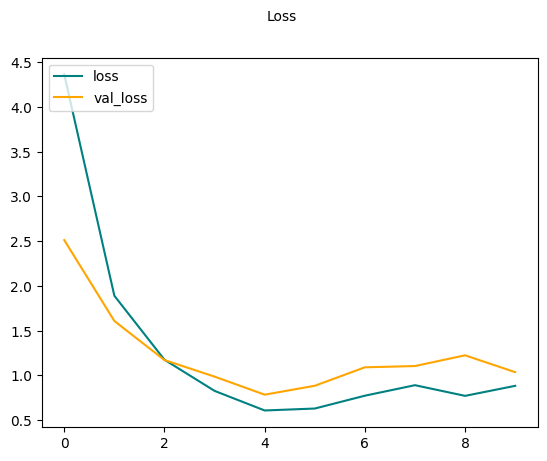

In [ ]:
fig = plt.figure()
plt.plot(hist_mob.history['loss'], color='teal', label='loss')
plt.plot(hist_mob.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper left")
plt.show()

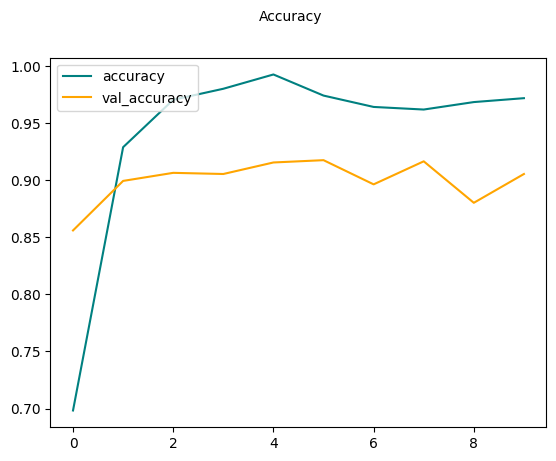

In [ ]:
fig = plt.figure()
plt.plot(hist_mob.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_mob.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="upper left")
plt.show()

### Evaluate the model

In [ ]:
test_loss, test_accuracy= mob_model.evaluate(test)

16/16 [==============================] - 66s 286ms/step - loss: 0.8192 - accuracy: 0.9117


In [ ]:
print('Loss:',test_loss)
print('Accuracy:', test_accuracy)

Loss: 0.819180428981781
Accuracy: 0.9117043018341064


In [ ]:
true_labels = []
predicted_labels = []

for batch in test.as_numpy_iterator():
    img, label = batch
    pred= mob_model.predict(img)

    true_labels.extend(label)
    predicted_labels.extend(np.argmax(pred, axis=1))



1/1 [==============================] - 0s 423ms/step


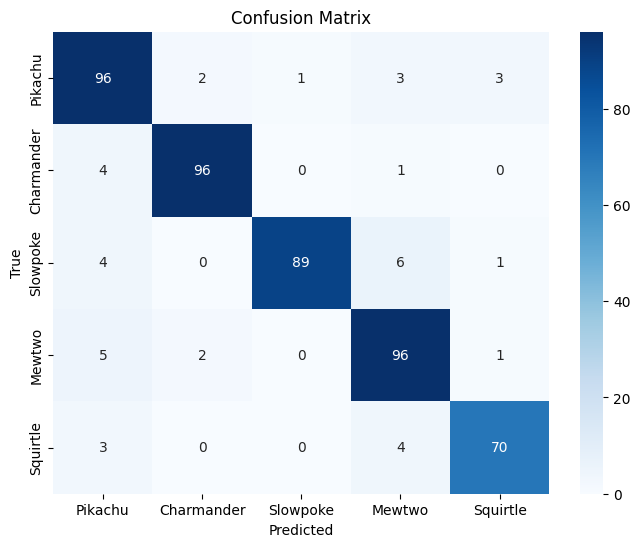

In [ ]:
# Calculate the confusion matrix for the entire test dataset
cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)

# Define class labels (modify as per your actual class labels)
class_labels = ['Pikachu', 'Charmander', 'Slowpoke', 'Mewtwo','Squirtle']

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Make predictions

In [ ]:
test_folder= '/content/drive/MyDrive/ML_project/test_images'

In [ ]:
file_paths = []

for root, dirs, files in os.walk(test_folder):
    for file_name in files:
      file_path = os.path.join(root, file_name)  # Construct the full file path
      file_paths.append(file_path)

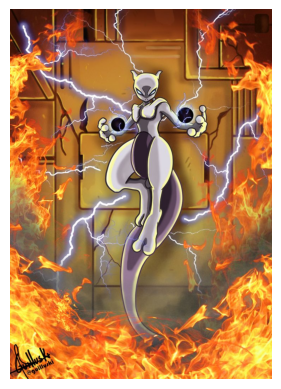

1/1 [==============================] - 0s 29ms/step
Prediction for /content/drive/MyDrive/ML_project/test_images/mew_10.jpeg
The predicted class is Mewtwo
Class Labels and Probabilities:
Charmander: 0.000001
Mewtwo: 0.999972
Pikachu: 0.000000
Slowpoke: 0.000003
Squirtle: 0.000023

=====



In [ ]:
random_file_paths = random.sample(file_paths, 1)

for image_path in random_file_paths:
    # Read the image
    pokemon_image = cv2.imread(str(image_path))

    # Display the image
    plt.imshow(cv2.cvtColor(pokemon_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Turn off axis labels
    plt.show()

    # Resize and preprocess the image
    image_resized = cv2.resize(pokemon_image, image_size)
    pokemon_image =np.expand_dims(image_resized/255, axis=0)

    # Make predictions using the model
    pred = mob_model.predict(pokemon_image)
    formatted_pred = [(label, prob) for label, prob in zip(class_names, pred[0])]

    # Get the output class with the highest probability
    output_class = class_names[np.argmax(pred)]

    # Print prediction information
    print("Prediction for", image_path)
    print("The predicted class is", output_class)
    print("Class Labels and Probabilities:")
    for label, prob in formatted_pred:
      print(f"{label}: {prob:.6f}")
    print("\n" + "="*5 + "\n")  # Separator between images

In [ ]:
#saving the model in google drive
mob_model.save(os.path.join('/content/drive/MyDrive/', 'pokemon__classifier_Mobilenet.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
